In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [45]:
predictions_dict = {}

In [46]:
config_filename = 'weights.yaml'
config = read_config(config_filename)

In [47]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
pulling from cache
loading from ../../misc/cache/dataframes_ts_22102020_tracker.pkl
splitting data ..
splitting data ..
          date      state district  total  active  recovered  deceased  \
0   2020-04-27  Jharkhand   Ranchi     75      63         10         2   
1   2020-04-28  Jharkhand   Ranchi     77      65         10         2   
2   2020-04-29  Jharkhand   Ranchi     78      66         10         2   
3   2020-04-30  Jharkhand   Ranchi     81      69         10         2   
4   2020-05-01  Jharkhand   Ranchi     83      71         10         2   
..         ...        ...      ...    ...     ...        ...       ...   
173 2020-10-17  Jharkhand   Ranchi  23948    2330      21461       157   
174 2020-10-18  Jharkhand   Ranchi  24146    2352      21634       160   
175 2020-10-19  Jharkhand   Ranchi  24298    2166      21972       160   
176 2020-10-20  Jharkhand   Ranchi  24494    2085      22247       162   
177 2020-10-21  Jharkhand   Ranchi  24657    

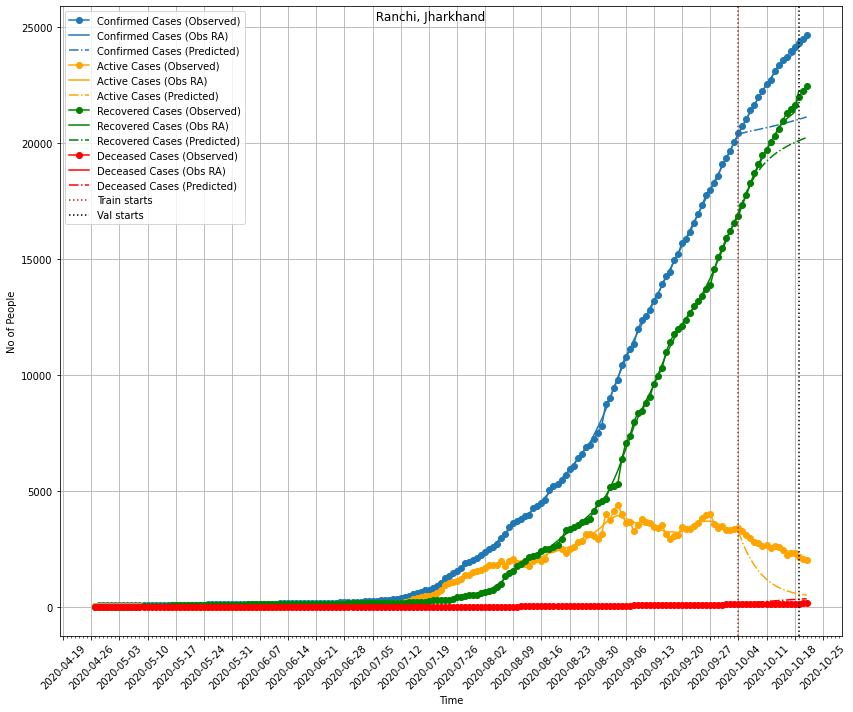

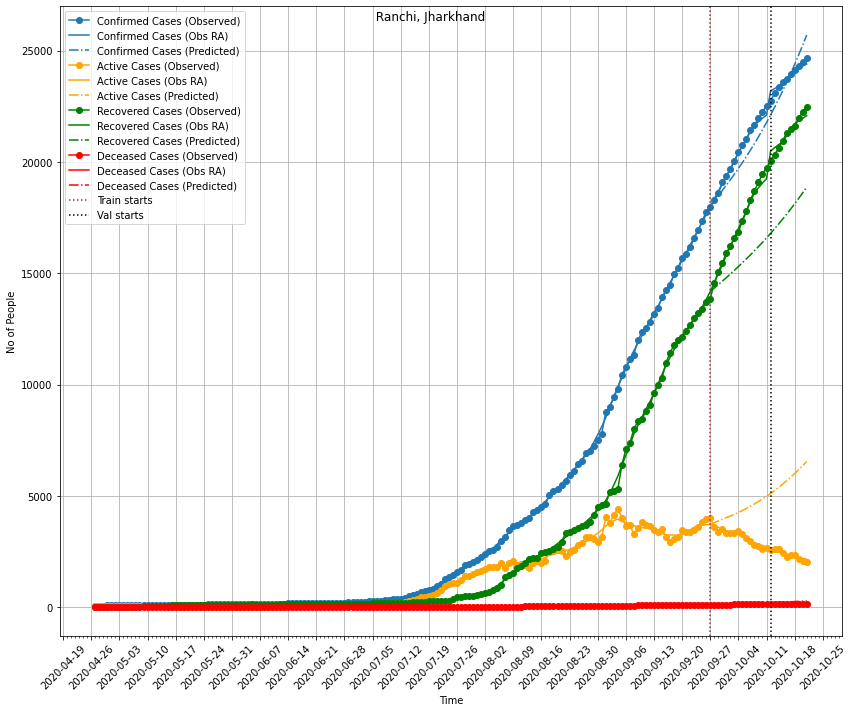

In [48]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 10
m2_params['split']['test_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)
# predictions_dict['m2'] = predictions_dict['m1']

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [49]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.022805297838681904,
 'I_hosp_ratio': 0.053482791178465106,
 'P_fatal': 0.09926916915066443,
 'T_inc': 4.73327996504643,
 'T_inf': 3.2996113816790897,
 'T_recov': 5.565437165699194,
 'T_recov_fatal': 15.80406217352766,
 'lockdown_R0': 1.304062874470354}

In [50]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.20291785615361224,
 'I_hosp_ratio': 0.22146555187331396,
 'P_fatal': 0.03866680601826414,
 'T_inc': 4.091226425598993,
 'T_inf': 3.2202638285233833,
 'T_recov': 24.007018099987892,
 'T_recov_fatal': 25.92088309452036,
 'lockdown_R0': 1.271237744766471}

## Loss Dataframes

### M1 Loss DataFrame

In [51]:
predictions_dict['m1']['df_loss']

train      val
total      7.66605  13.9206
active     48.4254   73.896
recovered   3.2299  9.25527
deceased   64.1696  120.591

### M2 Loss DataFrame

In [52]:
predictions_dict['m2']['df_loss']

train      val
total      2.67393  2.05513
active     37.8546  150.167
recovered  9.55006   16.462
deceased   17.2251  55.1224

## Sensitivity Plot

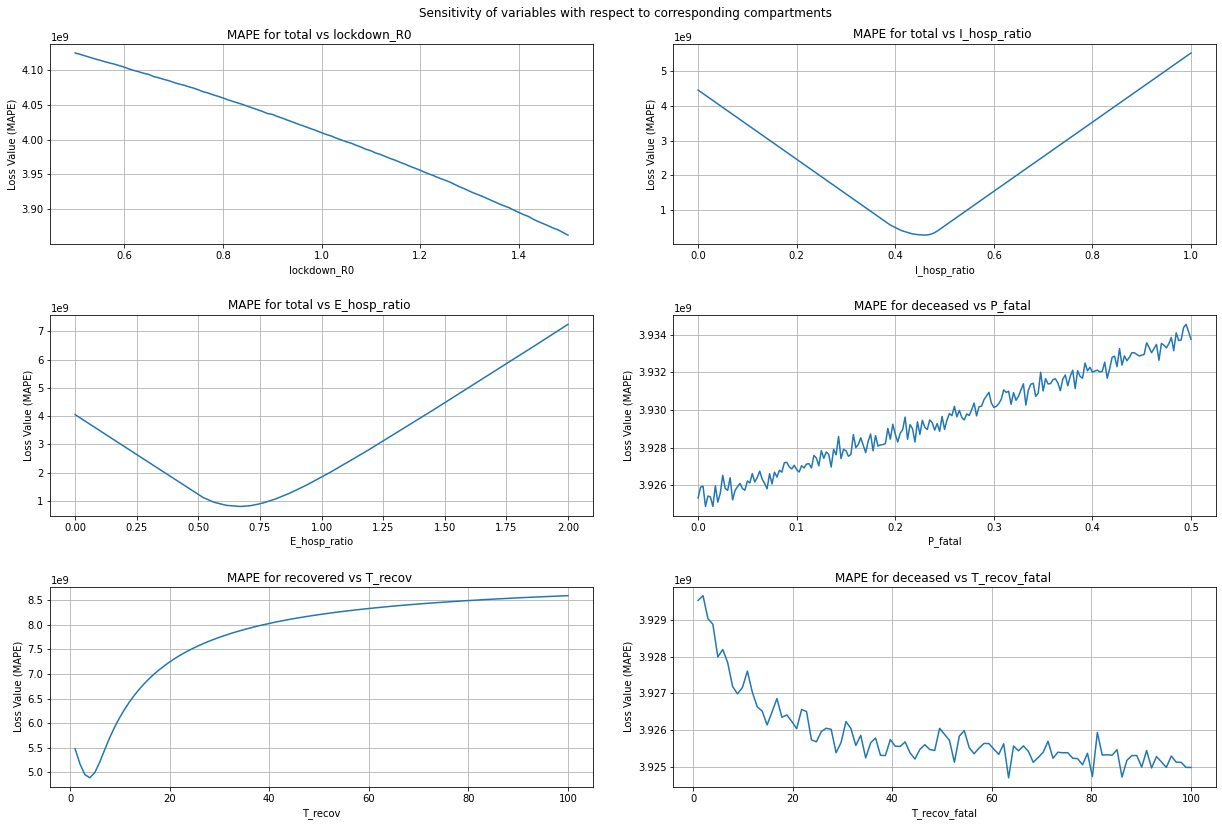

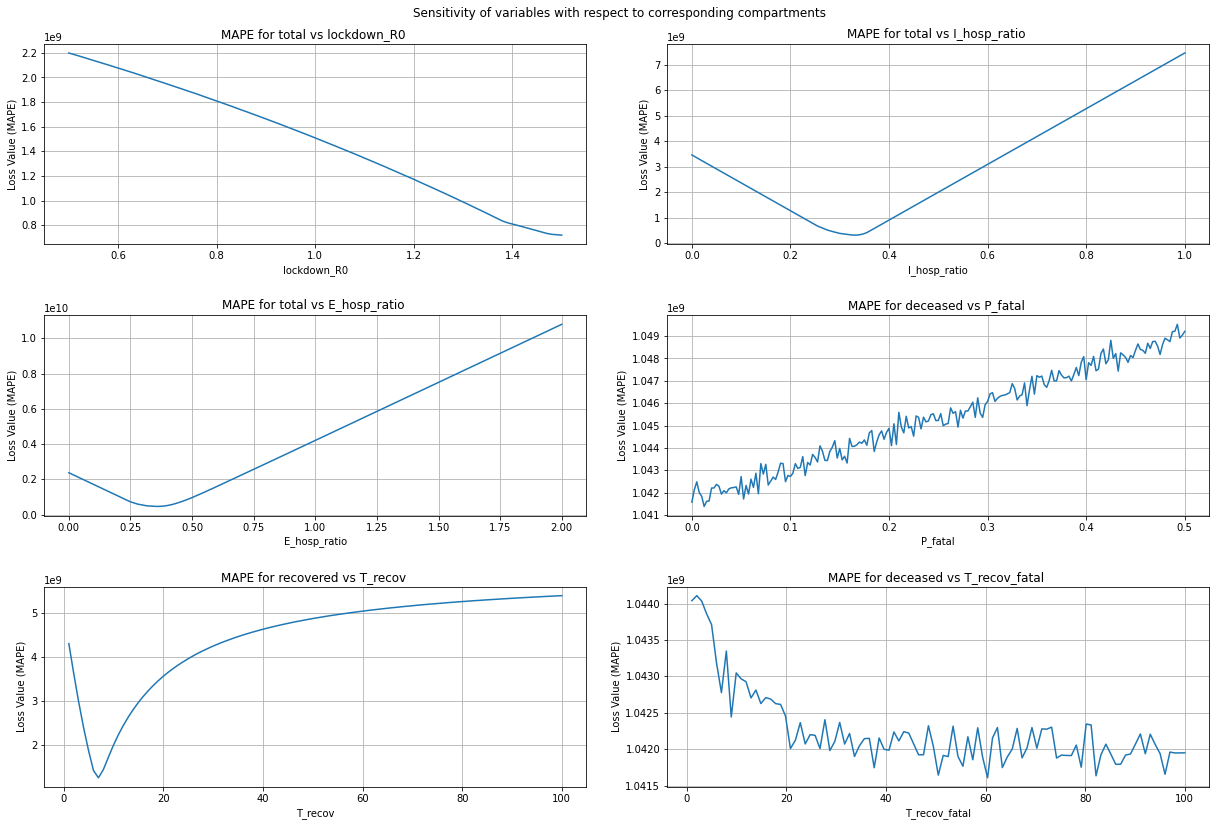

In [53]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [54]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date        S     E     I  R_recov  R_fatal      C     D  active  \
0  2020-09-27  3280426   752   821     3565      143  14183   106    3708   
1  2020-09-28  3280114   865   773     3652      147  14333   112    3799   
2  2020-09-29  3279815   943   758     3726      150  14487   118    3876   
3  2020-09-30  3279517  1003   760     3796      154  14644   123    3950   
4  2020-10-01  3279216  1052   773     3866      157  14803   129    4023   
..        ...      ...   ...   ...      ...      ...    ...   ...     ...   
65 2020-12-01  3220378  7967  5696    23082      968  40770  1136   24050   
66 2020-12-02  3218149  8218  5877    23833     1000  41747  1173   24833   
67 2020-12-03  3215852  8475  6063    24606     1032  42756  1213   25638   
68 2020-12-04  3213483  8740  6255    25403     1065  43797  1253   26468   
69 2020-12-05  3211042  9012  6451    26225     1100  44872  1295   27325   

    recovered  deceased  total  
0       14183       106  17997  
1       

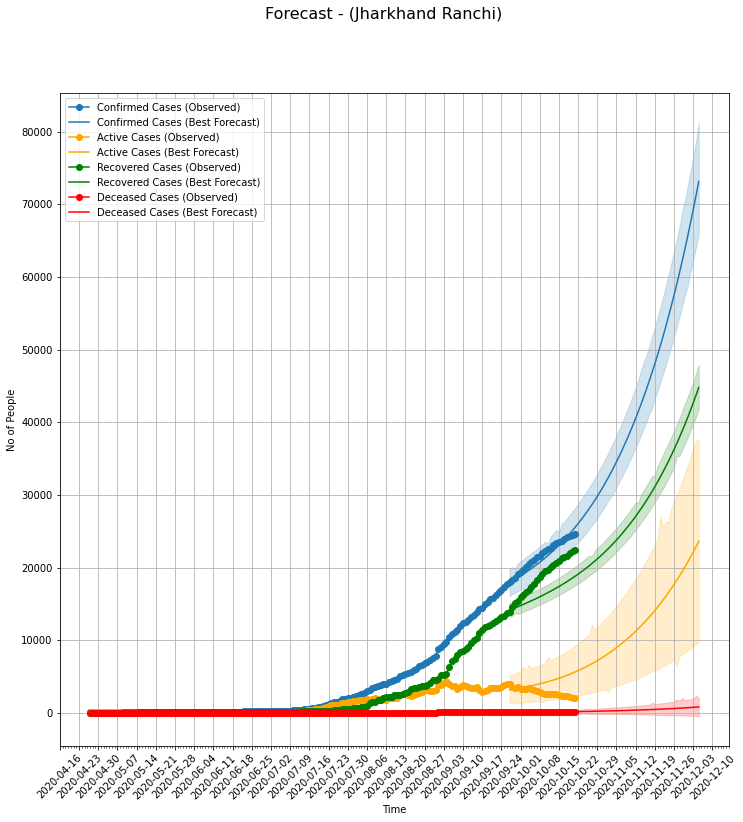

In [55]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [56]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

20it [00:00, 102.82it/s]getting forecasts ..



In [57]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

20it [00:00, 106.55it/s]getting forecasts ..



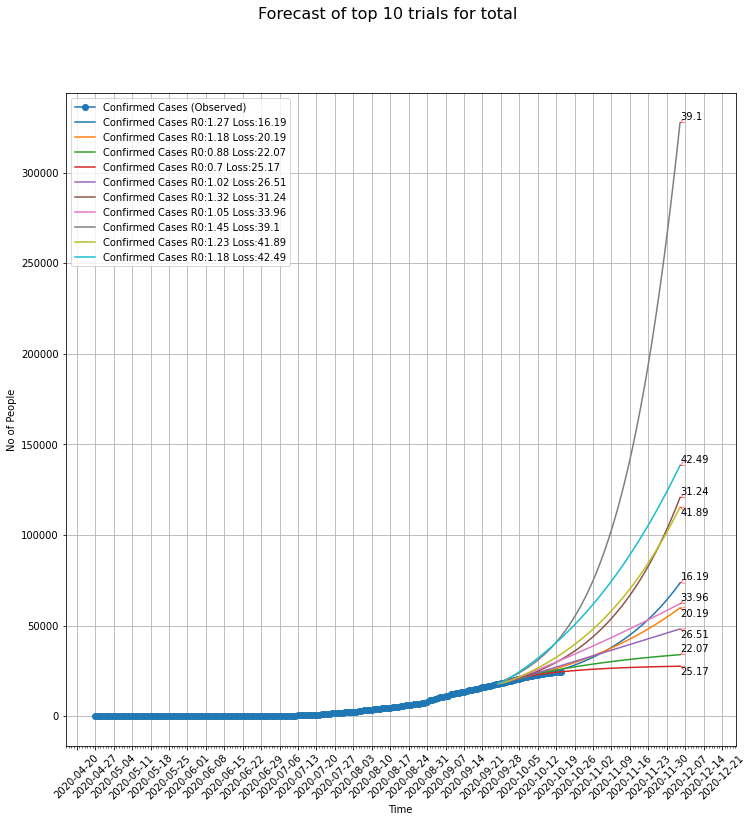

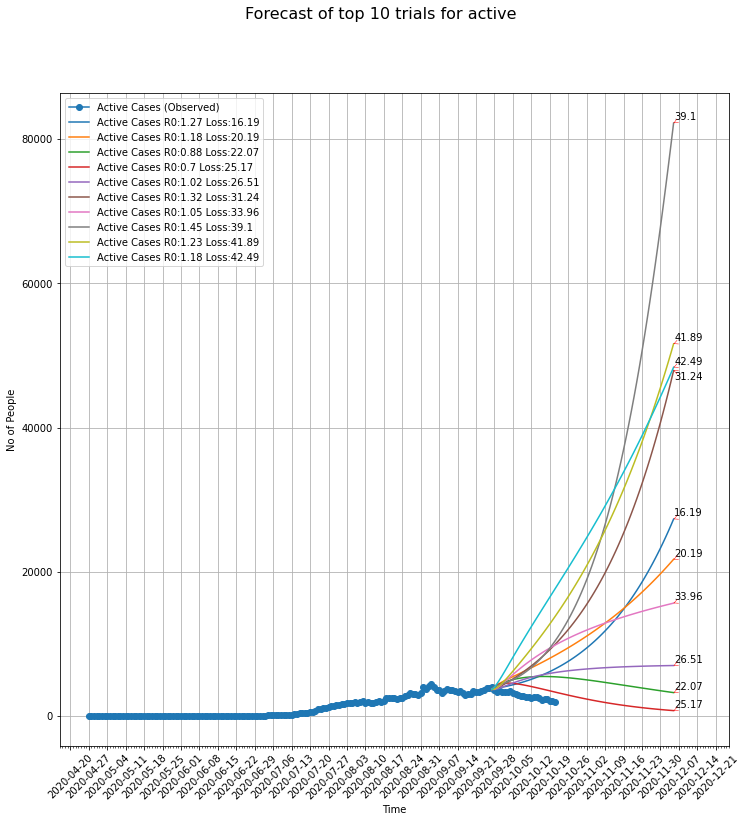

In [58]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [59]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [60]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:01<00:00, 58.98trial/s, best loss: 32.26781729951242]


In [61]:
uncertainty.beta_loss

{'active': 4.540834055247858,
 'recovered': 7.9935715093481905,
 'deceased': 110.31017602723016,
 'total': 6.226687606223485}

In [62]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [63]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

[         date        S     E     I  R_recov  R_fatal      C     D  active  \
0  2020-09-27  3280426   752   821     3565      143  14183   106    3708   
1  2020-09-28  3280114   865   773     3652      147  14333   112    3799   
2  2020-09-29  3279815   943   758     3726      150  14487   118    3876   
3  2020-09-30  3279517  1003   760     3796      154  14644   123    3950   
4  2020-10-01  3279216  1052   773     3866      157  14803   129    4023   
..        ...      ...   ...   ...      ...      ...    ...   ...     ...   
65 2020-12-01  3220378  7967  5696    23082      968  40770  1136   24050   
66 2020-12-02  3218149  8218  5877    23833     1000  41747  1173   24833   
67 2020-12-03  3215852  8475  6063    24606     1032  42756  1213   25638   
68 2020-12-04  3213483  8740  6255    25403     1065  43797  1253   26468   
69 2020-12-05  3211042  9012  6451    26225     1100  44872  1295   27325   

    recovered  deceased  total  
0       14183       106  17997  
1       

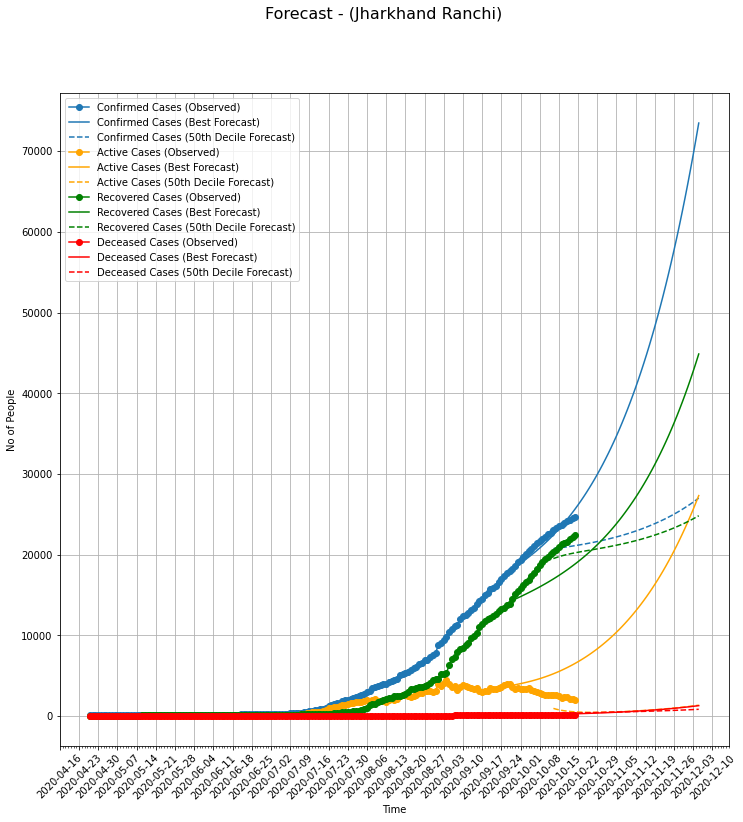

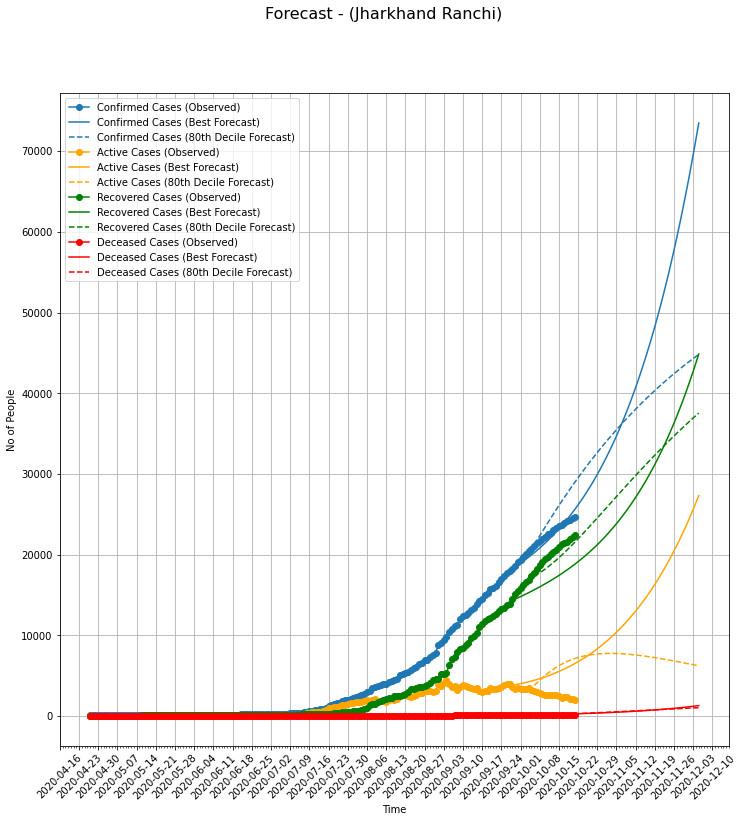

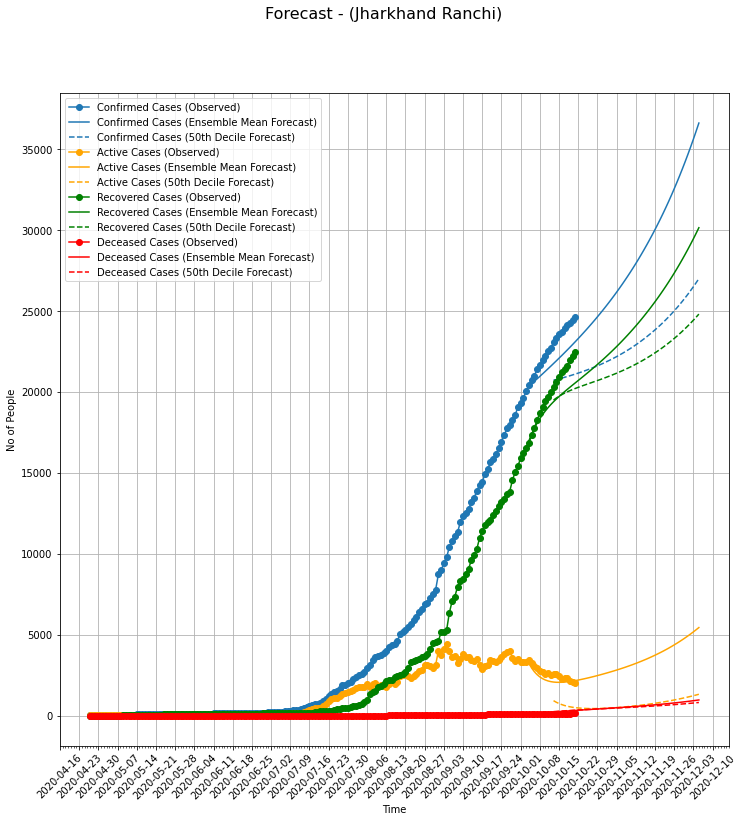

In [64]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

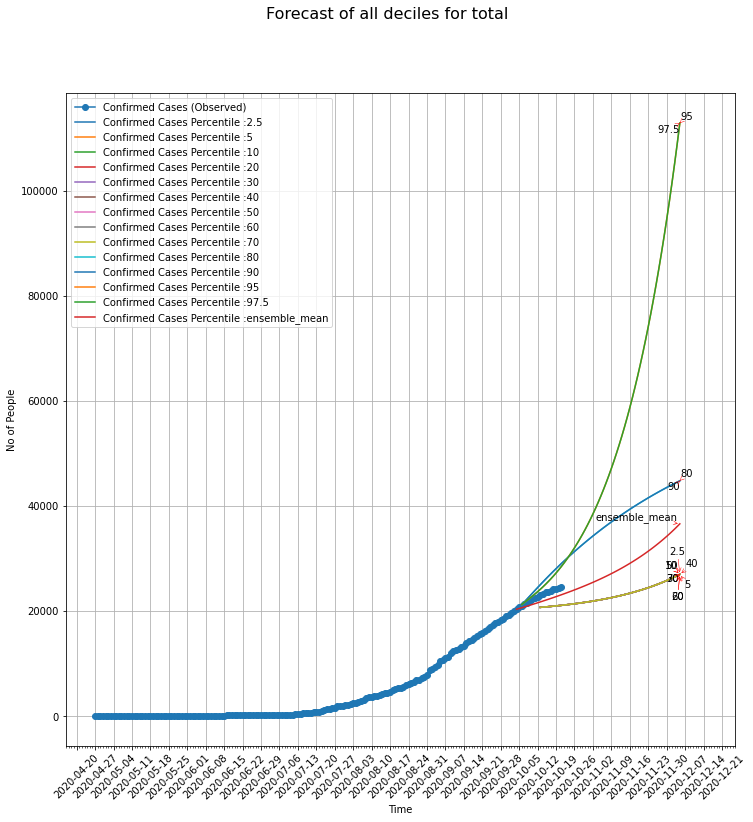

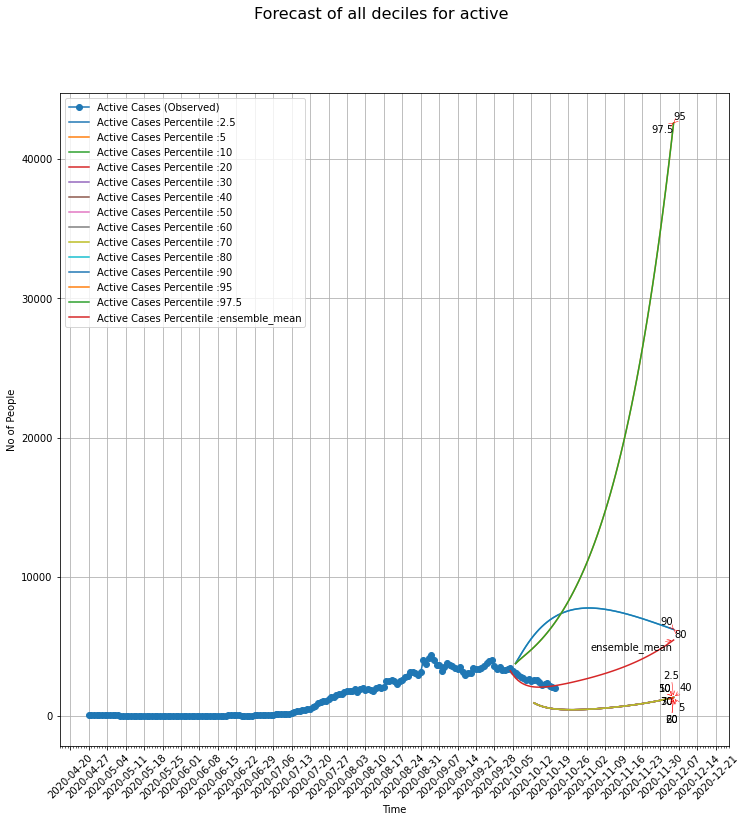

In [65]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


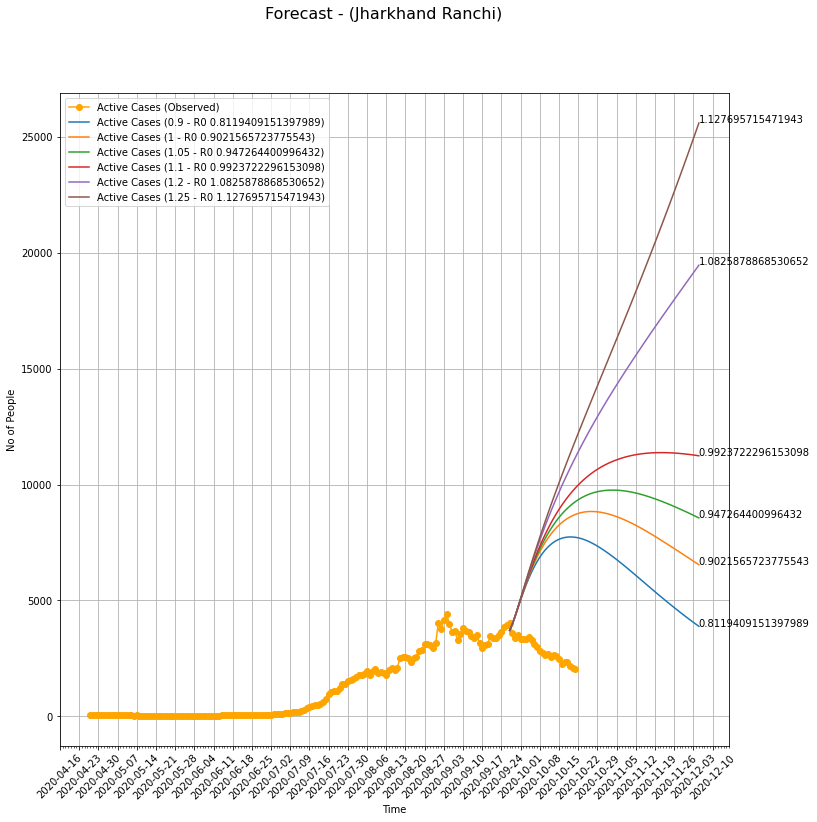

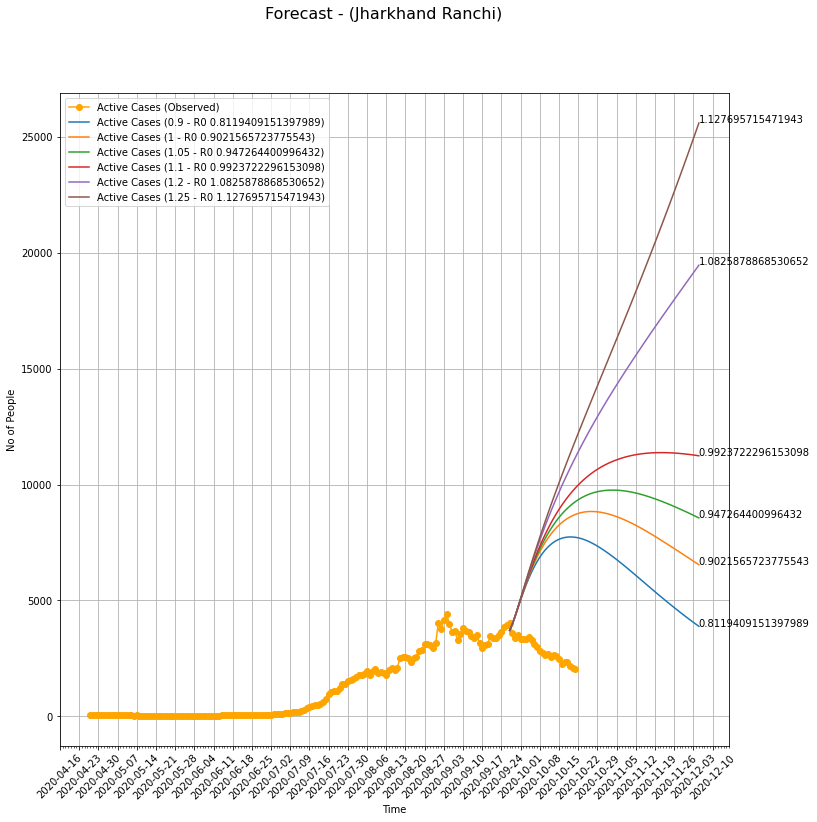

In [66]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [67]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [68]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [69]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [70]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [71]:
save_r0_mul(predictions_mul_dict, output_folder)

## Create df_district Output

In [72]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')